# Register MALDI to IMC multichannel image (serial)

With the affine transform matrices generated via the napari affinder image, transform (upsample) the maldi image to the imc roi.
The output image would be cropped to the same x,y dimension as the imc roi. 

## Set up dependency

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import napari
import os
import tifffile as tif
import scipy.ndimage as ndi
import skimage as ski

In [2]:
# load local modules
import sys
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'package'))
print(sys.path)

['/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python310.zip', '/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10', '/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/lib-dynload', '', '/home/ubuntu/miniconda3/envs/IMCanalysis/lib/python3.10/site-packages', '/home/ubuntu/code/package']


In [3]:
from maldi_to_imc import maldi_affine_to_imc

## Set up inputs

In [4]:
roi_origin = [12491, 27418, 0]

In [13]:
data_dir = '/mnt/central_nas/datasharing/Quentin/IMC_MALDI_gutenTAG'
imc_dir = os.path.join(data_dir, 'IMC//2609/20250304_QH_MALDI_IMC_GutenTAG_JA_2609/img')

affine_dir = os.path.join(data_dir, 'Registered/affine_matrices_2609/multiple_registration')
imc_file_name = '20250304_QH_MALDI_IMC_GutenTAG_JA_2609_004.tiff'
maldi_file_name = 'multichannel_image.tif'

output_dir = os.path.join(data_dir, 'Registered/registered_2609')

# to be changed
maldi_dir = os.path.join(data_dir, 'MALDI//2609/WU323417_result_qhelli_20250317_2609_ito/output')
# naming: sample2ref
affine_maldi2crater_name = 'ITO_MALDI_right_to_Ref_Craters_S3_2609.txt'
affine_crater2maldihe_name = 'Craters_ITO_S3_to_Ref_ITO_S3_2609.txt'
affine_maldihe2imc_name = 'ITO_S3_to_Ref_MCD_2609.txt'

transform_file_name = 'ITO_MALDI_right_to_IMC_2609_serial.tiff'

In [10]:
imc = tif.imread(os.path.join(imc_dir, imc_file_name))
# flip the first dimension up-down
imc = np.flip(imc, axis=1)
maldi = tif.imread(os.path.join(maldi_dir, maldi_file_name))

affine_maldi2crater = np.loadtxt(os.path.join(affine_dir, affine_maldi2crater_name), delimiter=',')
affine_crater2maldihe = np.loadtxt(os.path.join(affine_dir, affine_crater2maldihe_name), delimiter=',')
affine_maldihe2imc = np.loadtxt(os.path.join(affine_dir, affine_maldihe2imc_name), delimiter=',')

affine_maldi2imc = np.linalg.inv(np.linalg.inv(affine_maldi2crater) @ np.linalg.inv(affine_crater2maldihe) @ np.linalg.inv(affine_maldihe2imc))

print(imc.shape)
print(maldi.shape)
print(affine_maldi2imc)

(26, 1985, 3584)
(25, 754, 1152)
[[ 4.38865230e+00 -2.00249536e+01  3.07640594e+04]
 [-1.90865093e+01 -5.47687187e+00  4.17209073e+04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Multichannel registration

In [15]:
# for a 8cpu-32gb RAM machine, n_jobs have to be smaller than 3
# use fast_alg=True for a faster algorithm without zero padding
transformed_maldi = maldi_affine_to_imc(maldi, imc, affine_maldi2imc, roi_origin, order=0, n_jobs=3, fast_alg=True)

/home/ubuntu/code/package/maldi_to_imc.py:14: RuntimeWarning: invalid value encountered in divide
  maldi_norm = ((maldi_sample - np.min(maldi_sample)) / (np.max(maldi_sample) - np.min(maldi_sample)) * 255).astype(np.uint8)
/home/ubuntu/code/package/maldi_to_imc.py:14: RuntimeWarning: invalid value encountered in cast
  maldi_norm = ((maldi_sample - np.min(maldi_sample)) / (np.max(maldi_sample) - np.min(maldi_sample)) * 255).astype(np.uint8)
/home/ubuntu/code/package/maldi_to_imc.py:14: RuntimeWarning: invalid value encountered in divide
  maldi_norm = ((maldi_sample - np.min(maldi_sample)) / (np.max(maldi_sample) - np.min(maldi_sample)) * 255).astype(np.uint8)
/home/ubuntu/code/package/maldi_to_imc.py:14: RuntimeWarning: invalid value encountered in cast
  maldi_norm = ((maldi_sample - np.min(maldi_sample)) / (np.max(maldi_sample) - np.min(maldi_sample)) * 255).astype(np.uint8)
/home/ubuntu/code/package/maldi_to_imc.py:14: RuntimeWarning: invalid value encountered in divide
  maldi_no

In [12]:
print(transformed_maldi.shape)
print(np.max(transformed_maldi))

(25, 1985, 3584)
255


In [16]:
# save the transformed maldi image
tif.imwrite(os.path.join(output_dir, transform_file_name), transformed_maldi, metadata={'axes': 'CYX'}, imagej=True)

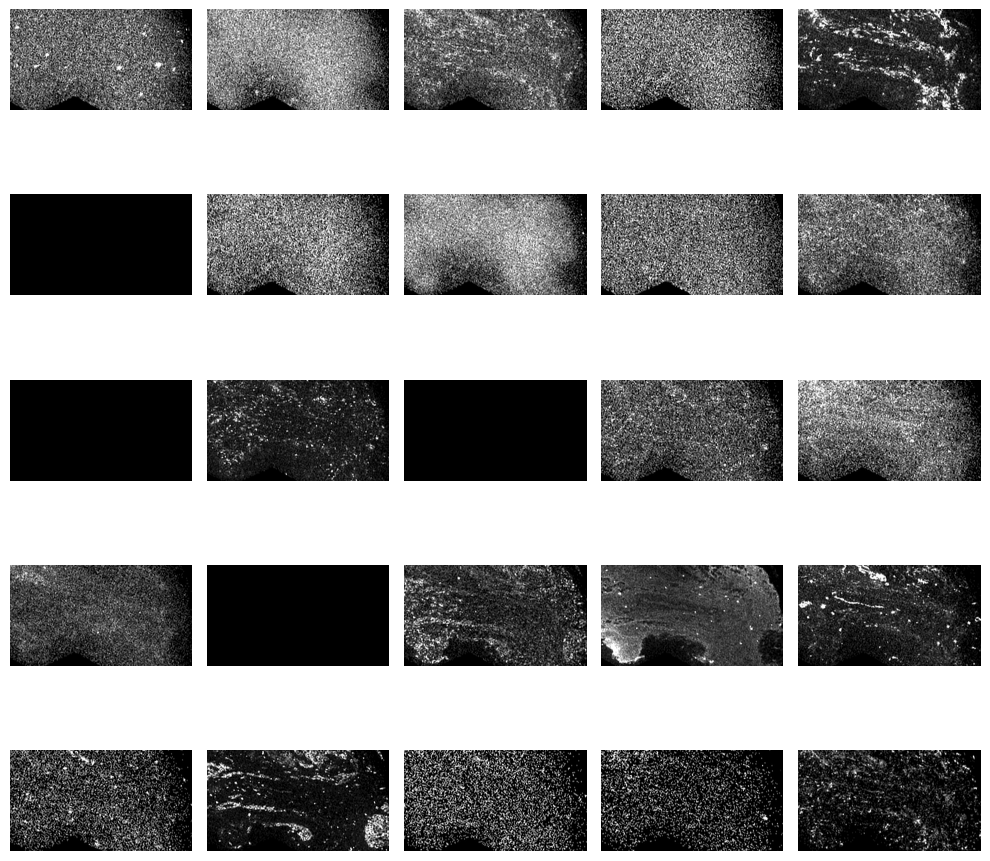

In [22]:
# plot the images
fig, axs = plt.subplots(5,5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axs[i,j].imshow(transformed_maldi[5*i+j], cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()